# WNBA ETL + Analytics Demo

This notebook demonstrates an example end-to-end data pipeline using WNBA game log data.
We extract and transform team box scores, generate analytics-ready datasets, and visualize insights relevant to game outcomes and 3-point shooting trends.

Created by N. Maxine Kennebrew | Powered by `sports_etl`

In [1]:
# Import your ETL pipeline
from sports_etl.etl.extract import load_team_stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!pwd

/home/maxkennebrew/projects/sports_etl_project/notebooks


In [5]:
from sports_etl.etl.extract import load_team_stats

df = load_team_stats("../data/wnba_gamelogs_2015_2024.csv")  # adjust filename if needed
df.head()

[INFO] Loaded 3942 rows × 41 columns from wnba_gamelogs_2015_2024.csv


,Season,Team,G#,Date,Home,Opp,W/L,Tm_Pts,Opp_Pts,Tm_FG,...,Opp_FT,Opp_FTA,Opp_FT%,Opp_ORB,Opp_TRB,Opp_AST,Opp_STL,Opp_BLK,Opp_TOV,Opp_PF
0,2015,ATL,1,2015-06-05,0,NYL,L,73,82,24,...,21,26,0.808,4,32,16,13,4,15,20
1,2015,ATL,2,2015-06-07,1,CON,L,70,75,25,...,12,19,0.632,8,25,14,18,3,11,24
2,2015,ATL,3,2015-06-11,1,SAS,W,72,69,28,...,16,18,0.889,8,29,19,6,7,17,18
3,2015,ATL,4,2015-06-12,0,WAS,W,64,61,24,...,10,12,0.833,11,32,15,7,2,15,18
4,2015,ATL,5,2015-06-14,0,CON,L,64,82,26,...,5,6,0.833,6,26,17,13,0,23,16


In [6]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(df.columns.tolist())

Rows: 3942, Columns: 41
['Season', 'Team', 'G#', 'Date', 'Home', 'Opp', 'W/L', 'Tm_Pts', 'Opp_Pts', 'Tm_FG', 'Tm_FGA', 'Tm_FG%', 'Tm_3P', 'Tm_3PA', 'Tm_3P%', 'Tm_FT', 'Tm_FTA', 'Tm_FT%', 'Tm_ORB', 'Tm_TRB', 'Tm_AST', 'Tm_STL', 'Tm_BLK', 'Tm_TOV', 'Tm_PF', 'Opp_FG', 'Opp_FGA', 'Opp_FG%', 'Opp_3P', 'Opp_3PA', 'Opp_3P%', 'Opp_FT', 'Opp_FTA', 'Opp_FT%', 'Opp_ORB', 'Opp_TRB', 'Opp_AST', 'Opp_STL', 'Opp_BLK', 'Opp_TOV', 'Opp_PF']


In [8]:
from sports_etl.etl.transform import transform_team_stats_my_dataset

df_clean = transform_team_stats_my_dataset(df)
print(df_clean.head())

[INFO] Transformed team stats — final shape after deduplication: (3940, 48)
[INFO] Transformed team stats with new features.


   Season Team  G#        Date  Home  Opp W/L  Tm_Pts  Opp_Pts  Tm_FG  ...  \
0    2015  ATL   1  2015-06-05     0  NYL   L      73       82     24  ...   
1    2015  ATL   2  2015-06-07     1  CON   L      70       75     25  ...   
2    2015  ATL   3  2015-06-11     1  SAS   W      72       69     28  ...   
3    2015  ATL   4  2015-06-12     0  WAS   W      64       61     24  ...   
4    2015  ATL   5  2015-06-14     0  CON   L      64       82     26  ...   

   Opp_BLK  Opp_TOV  Opp_PF  win_margin  Tm_poss  Opp_poss  Tm_off_rating  \
0        4       15      20          -9    83.68     82.44      87.237094   
1        3       11      24          -5    83.92     82.36      83.412774   
2        7       17      18           3    78.92     78.92      91.231627   
3        2       15      18           3    74.40     72.28      86.021505   
4        0       23      16         -18    83.28     78.64      76.849183   

   Tm_def_rating  Tm_tov_rate  Opp_tov_rate  
0      99.466279     0

In [11]:
df_clean['3PT_Share'] = (df_clean['Tm_3P'] * 3) / df_clean['Tm_Pts'] * 100

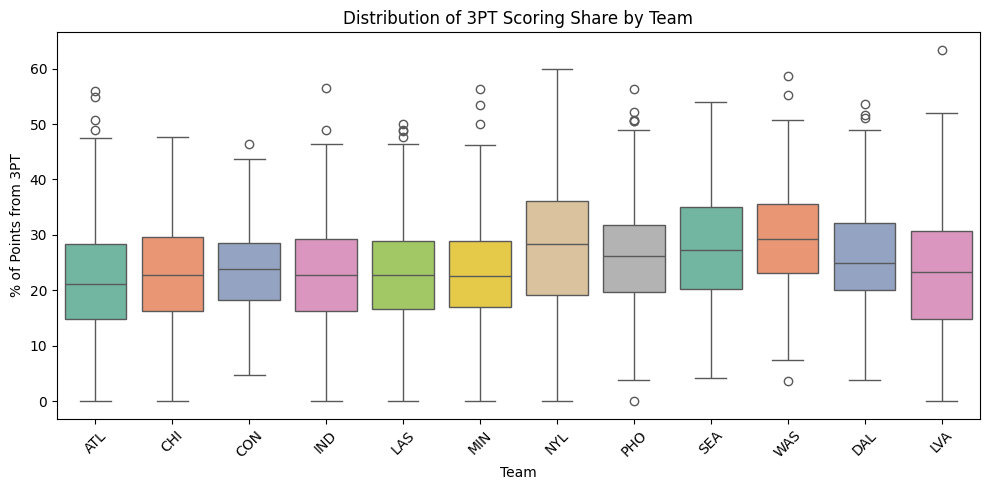

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_clean, x='Team', y='3PT_Share', hue='Team', palette='Set2', ax=ax, legend=False)
ax.set_title("Distribution of 3PT Scoring Share by Team")
ax.set_ylabel("% of Points from 3PT")
plt.xticks(rotation=45)
plt.tight_layout()

In [15]:
df_2024_q1 = df[(df['Season'] == 2024) & (df['G#'] <= 11)].copy()

In [16]:
q1_3pt_summary = (
    df_2024_q1.groupby("Team")[['Tm_3P', 'Tm_Pts']]
    .sum()
    .assign(ThreeP_Share=lambda x: x['Tm_3P'] * 3 / x['Tm_Pts'] * 100)
    .sort_values("ThreeP_Share", ascending=False)
)
q1_3pt_summary.head()

,Tm_3P,Tm_Pts,ThreeP_Share
Team,,,
PHO,108,867,37.370242
MIN,117,940,37.340426
WAS,92,808,34.158416
LVA,109,960,34.062500
NYL,99,941,31.562168


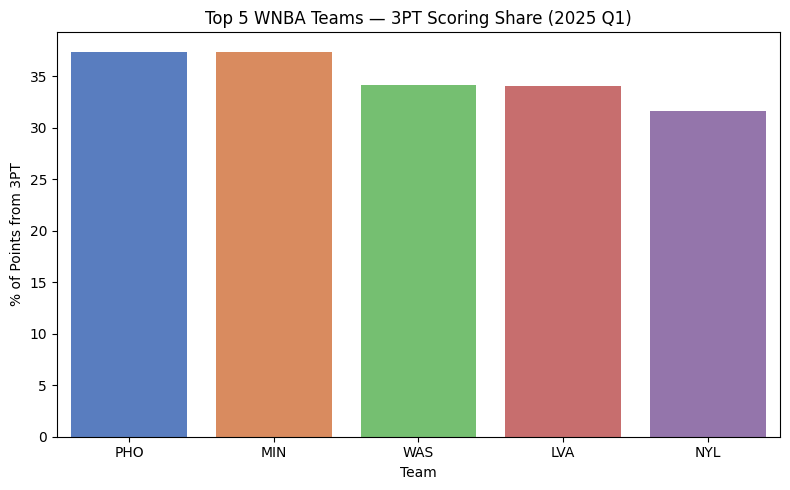

In [18]:
top5 = q1_3pt_summary.head(5).reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=top5, x='Team', y='ThreeP_Share', palette='muted', hue = 'Team', ax=ax)
ax.set_title("Top 5 WNBA Teams — 3PT Scoring Share (2025 Q1)")
ax.set_ylabel("% of Points from 3PT")
plt.tight_layout()

## Summary

This notebook demonstrates:

- Loading and transforming team box score data from CSV
- Creating derived features like 3PT scoring share
- Producing quick team-level insights through visuals

For more WNBA analytics, visual storytelling, and game-day breakdowns, follow along:
- 📸 Instagram: [@playher.ai](https://www.instagram.com/playher.ai)
- 📊 Kaggle: [natoshakennebrew](https://www.kaggle.com/natoshakennebrew)

---